In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


def plot_fit_with_params(data, dist, true_params, dist_name, fit_kwargs=None):
    if fit_kwargs is None:
        fit_kwargs = {}

    # Fitaj s poljubnimi dodatnimi argumenti (npr. floc=0, fscale=1)
    fitted_params = dist.fit(data, **fit_kwargs)

    # Pripravi podatke za PDF
    x = np.linspace(min(data), max(data), 1000)
    pdf_fitted = dist.pdf(x, *fitted_params)

    # Vizualizacija
    plt.figure(figsize=(8, 4))
    plt.hist(data, bins=30, density=True, alpha=0.5, label='Podatki')
    plt.plot(x, pdf_fitted, 'r-', label='Fittana PDF')
    plt.title(f'{dist_name} - Fit porazdelitve')
    plt.xlabel('x')
    plt.ylabel('Gostota')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Izpis parametrov
    print(f"--- {dist_name} ---")
    print("Pravi parametri:   ", true_params)
    print("Fittani parametri: ", tuple(round(float(p), 4) for p in fitted_params))
    print()
    
    return fitted_params

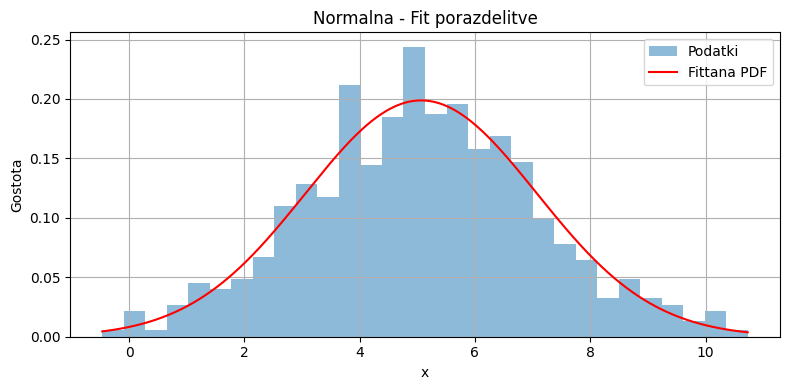

--- Normalna ---
Pravi parametri:    (5, 2)
Fittani parametri:  (5.0677, 2.007)



In [32]:
data_norm = np.random.normal(loc=5, scale=2, size=1000)
true_params_norm = (5, 2)
fitted_params = plot_fit_with_params(data_norm, stats.norm, true_params_norm, "Normalna")

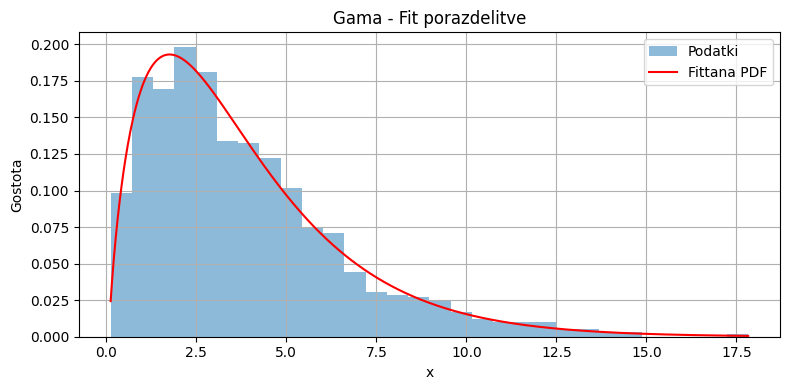

--- Gama ---
Pravi parametri:    (2, 0, 2)
Fittani parametri:  (1.81, 0.0727, 2.0799)



In [33]:
data_gamma = np.random.gamma(shape=2, scale=2, size=1000)
true_params_gamma = (2, 0, 2)  # (a, loc, scale)
fitted_params = plot_fit_with_params(data_gamma, stats.gamma, true_params_gamma, "Gama")

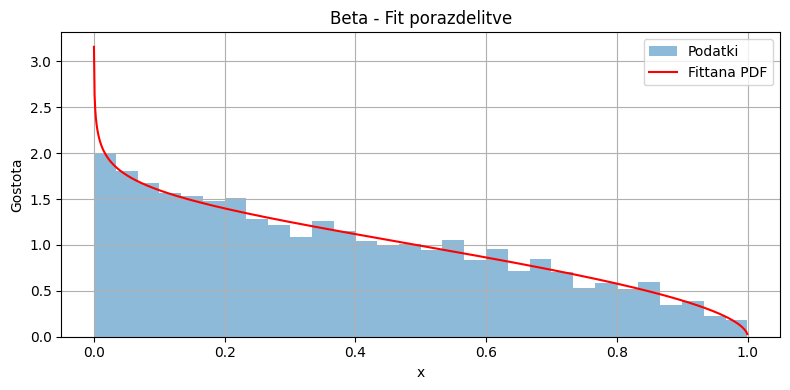

--- Beta ---
Pravi parametri:    (0.9, 1.5, 0, 1)
Fittani parametri:  (0.9, 1.537, 0.0, 1.0)



In [53]:
data_beta = np.random.beta(a=0.9, b=1.5, size=5000)
true_params_beta = (0.9, 1.5, 0, 1)  # (a, b, loc, scale)
# Če smo prepričani, da a=2, ga lahko fiksiramo z dodajanjem "f0": 2, v slovar znanih vrednosti. Če bi poznali b, bi dodali "f1": b
fitted_params = plot_fit_with_params(data_beta, stats.beta, true_params_beta, "Beta", fit_kwargs={"f0": true_params_beta[0], "floc": 0, "fscale": 1})


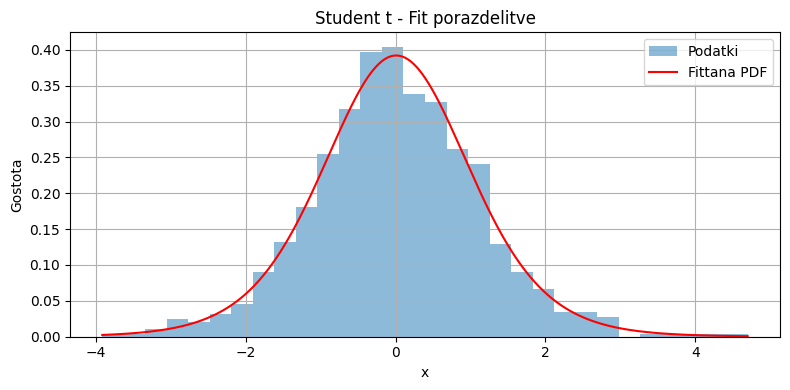

--- Student t ---
Pravi parametri:    (10, 0, 1)
Fittani parametri:  (9.1604, 0.0089, 0.9903)



In [35]:
data_t = stats.t.rvs(df=10, loc=0, scale=1, size=1000)
true_params_t = (10, 0, 1)  # (df, loc, scale)
fitted_params = plot_fit_with_params(data_t, stats.t, true_params_t, "Student t")

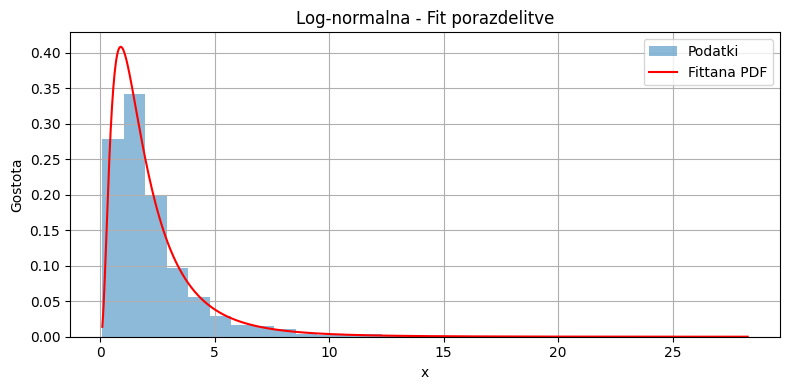

--- Log-normalna ---
Pravi parametri:    (0.8, 0, np.float64(1.6487212707001282))
Fittani parametri:  (0.7775, -0.0345, 1.6988)



In [36]:
data_lognorm = np.random.lognormal(mean=0.5, sigma=0.8, size=2000)
true_params_lognorm = (0.8, 0, np.exp(0.5))  # (s, loc, scale)
fitted_params = plot_fit_with_params(data_lognorm, stats.lognorm, true_params_lognorm, "Log-normalna")

# 📘 Marčenko–Pastur filtracija (RMT)

**Cilj**: Odstraniti šum iz kovariančne matrike visokodimenzionalnih donosov z uporabo teorije naključnih matrik (RMT).

---

## 🏗️ Struktura kode

* **`generate_returns_with_factors(n, p, k)`**
  Simulira donose s skritimi faktorji:
  `returns = factors @ loadings + noise`

* **`marcenko_pastur_pdf(x, λ)`**
  Gostota šumnega spektra; velja v `[a, b]` z:
  `a = (1−√λ)²`, `b = (1+√λ)²`

* **`fit_lambda(eigenvals)`**
  Najde optimalno λ z maksimumom verjetnosti (fit na lastne vrednosti).

* **`filter_covariance(cov, λ)`**
  Povpreči šumne lastne vrednosti (znotraj `[a, b]`) → rekonstruira filtrirano matriko.

* **`compare_variances(...)`**
  Primerja variance in portfeljsko volatilnost pred/po filtraciji.

* **`evaluate_filtering_effectiveness(...)`**
  Izračuna Frobeniusovo napako glede na pravo signalno matriko (iz `loadings`) + % izboljšanja.

---

## 🔁 Glavni tok

1. Generiraj podatke
2. Izračunaj kovariančno matriko
3. Fit λ in filtriraj spekter
4. Vizualizacija + primerjava variance
5. Kvantitativna ocena napake

---

## ✅ Namen

Oceni, koliko **filtracija z MP zakonom** pomaga znižati napako v oceni kovariančne matrike (t.j. ločevanje signala od šuma).

Ocenjena lambda: 0.2328
Teoretična lambda (p/n): 0.2500
Marčenko-Pastur interval: [0.2678, 2.1977]


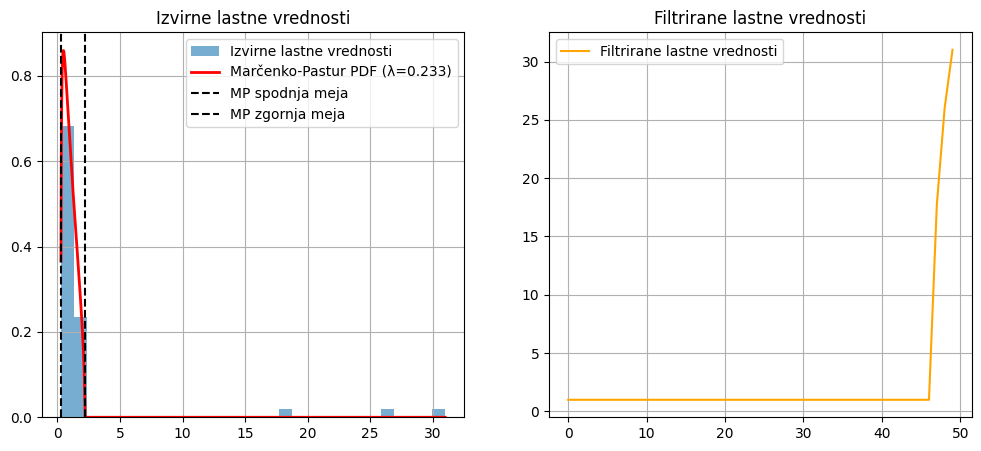

Prvih 10 varianc iz izvirne kovariančne matrike:
[3.3831 2.5587 1.6047 3.2634 5.9338 2.5977 1.8081 3.0453 4.2201 2.5052]

Prvih 10 varianc iz filtrirane kovariančne matrike:
[3.2718 2.7086 1.6278 3.4057 5.9943 2.2646 1.9097 2.8934 4.2199 2.6864]

Portfeljska varianca z izvirno matriko: 0.0700
Portfeljska varianca s filtrirano matriko: 0.0722

Filtracija pomaga odstraniti šum in stabilizirati ocene kovariančne matrike.
Napaka originalne matrike: 11.6636
Napaka filtrirane matrike: 11.1836
Popravek po filtraciji: 4.12%


In [ ]:
from scipy.optimize import minimize

# --- 1. Generiranje donosa z latentnimi faktorji ---
def generate_returns_with_factors(n, p, k, signal_strength=0.5, noise_std=1.0, seed=42):
    np.random.seed(seed)
    factors = np.random.normal(0, 1, (n, k))
    loadings = np.random.normal(0, signal_strength, (k, p))
    signal = factors @ loadings
    noise = np.random.normal(0, noise_std, (n, p))
    returns = signal + noise
    return returns, loadings

# --- 2. Marčenko-Pastur PDF ---
def marcenko_pastur_pdf(x, lam):
    a = (1 - np.sqrt(lam))**2
    b = (1 + np.sqrt(lam))**2
    pdf = np.zeros_like(x)
    mask = (x >= a) & (x <= b)
    pdf[mask] = (1 / (2 * np.pi * lam * x[mask])) * np.sqrt((b - x[mask]) * (x[mask] - a))
    return pdf

# --- 3. Negativna log-verjetnost za fit ---
def neg_log_likelihood(lam, data):
    if lam <= 0 or lam > 1:
        return np.inf
    pdf_vals = marcenko_pastur_pdf(data, lam)
    epsilon = 1e-12
    pdf_vals = np.clip(pdf_vals, epsilon, None)
    return -np.sum(np.log(pdf_vals))

# --- 4. Fit lambda ---
def fit_lambda(eigenvals):
    res = minimize(lambda lam: neg_log_likelihood(lam, eigenvals), x0=0.5, bounds=[(0.01, 1)])
    return res.x[0]

# --- 5. Filtracija kovariančne matrike po MP ---
def filter_covariance(cov_matrix, lambda_fit):
    eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)
    a = (1 - np.sqrt(lambda_fit))**2
    b = (1 + np.sqrt(lambda_fit))**2

    mask_noise = (eigenvals >= a) & (eigenvals <= b)
    mean_noise = np.mean(eigenvals[mask_noise])

    eigenvals_filtered = eigenvals.copy()
    eigenvals_filtered[mask_noise] = mean_noise

    cov_filtered = eigenvecs @ np.diag(eigenvals_filtered) @ eigenvecs.T
    return cov_filtered, eigenvals, eigenvals_filtered, a, b

# --- 6. Vizualizacija ---
def plot_results(eigenvals, eigenvals_filtered, a, b, lambda_fit):
    x_vals = np.linspace(min(eigenvals), max(eigenvals), 1000)
    mp_pdf_vals = marcenko_pastur_pdf(x_vals, lambda_fit)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.hist(eigenvals, bins=30, density=True, alpha=0.6, label='Izvirne lastne vrednosti')
    plt.plot(x_vals, mp_pdf_vals, 'r-', lw=2, label=f'Marčenko-Pastur PDF (λ={lambda_fit:.3f})')
    plt.axvline(a, color='k', linestyle='--', label='MP spodnja meja')
    plt.axvline(b, color='k', linestyle='--', label='MP zgornja meja')
    plt.title('Izvirne lastne vrednosti')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(np.sort(eigenvals_filtered), color='orange', label='Filtrirane lastne vrednosti')
    plt.title('Filtrirane lastne vrednosti')
    plt.legend()
    plt.grid(True)

    plt.show()

# --- 7. Primerjava varianc in portfeljske variance ---
def compare_variances(cov_matrix, cov_filtered, p):
    print("Prvih 10 varianc iz izvirne kovariančne matrike:")
    print(np.round(np.diag(cov_matrix)[:10], 4))

    print("\nPrvih 10 varianc iz filtrirane kovariančne matrike:")
    print(np.round(np.diag(cov_filtered)[:10], 4))

    weights = np.random.dirichlet(np.ones(p))
    var_orig = weights @ cov_matrix @ weights
    var_filt = weights @ cov_filtered @ weights

    print(f"\nPortfeljska varianca z izvirno matriko: {var_orig:.4f}")
    print(f"Portfeljska varianca s filtrirano matriko: {var_filt:.4f}")
    print("\nFiltracija pomaga odstraniti šum in stabilizirati ocene kovariančne matrike.")
    
# -- Ocenimo kakovost --
def evaluate_filtering_effectiveness(cov_orig, cov_filtered, loadings):
    # Teoretična signalna kovariančna matrika
    true_cov_signal = loadings.T @ loadings

    # Napaka glede na signal
    err_orig = np.linalg.norm(cov_orig - true_cov_signal, ord='fro')
    err_filt = np.linalg.norm(cov_filtered - true_cov_signal, ord='fro')

    improvement = (err_orig - err_filt) / err_orig * 100

    print(f"Napaka originalne matrike: {err_orig:.4f}")
    print(f"Napaka filtrirane matrike: {err_filt:.4f}")
    print(f"Popravek po filtraciji: {improvement:.2f}%")

    return err_orig, err_filt, improvement

# --- Glavni program ---
def main():
    # Parametri
    n, p, k = 200, 50, 3
    returns, loadings = generate_returns_with_factors(n, p, k, signal_strength=0.7, noise_std=1.0, seed=42)

    cov_matrix = np.cov(returns, rowvar=False)
    eigenvals, _ = np.linalg.eigh(cov_matrix)

    lambda_fit = fit_lambda(eigenvals)
    print(f"Ocenjena lambda: {lambda_fit:.4f}")
    print(f"Teoretična lambda (p/n): {p/n:.4f}")

    cov_filtered, eigenvals_orig, eigenvals_filtered, a, b = filter_covariance(cov_matrix, lambda_fit)
    print(f"Marčenko-Pastur interval: [{a:.4f}, {b:.4f}]")

    plot_results(eigenvals_orig, eigenvals_filtered, a, b, lambda_fit)
    compare_variances(cov_matrix, cov_filtered, p)
    
    evaluate_filtering_effectiveness(cov_matrix, cov_filtered, loadings)


if __name__ == "__main__":
    main()
